In [57]:
!hostname

jupyterhub-3bcf55a276a1a6-jupyterhub-0


In [121]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pandas as pd
import argparse
from pytube import YouTube
from tqdm import tqdm
import cv2
import numpy as np
import joblib
import time

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import albumentations
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt

In [59]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [60]:
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}
kwargs

{}

In [61]:
DIR_HOME = '/home/jupyter-admin'
DIR_DATASETS = DIR_HOME + '/datasets'
DIR_DATASET_MSASL = DIR_DATASETS + '/MS-ASL'
DIR_VIDEOS = DIR_DATASET_MSASL + '/videos'
DIR_IMAGES = DIR_DATASET_MSASL + '/images'

In [62]:
print(f'DIR_HOME: {DIR_HOME}')
print(f'DIR_DATASETS: {DIR_DATASETS}')
print(f'DIR_DATASET_MSASL: {DIR_DATASET_MSASL}')
print(f'DIR_VIDEOS: {DIR_VIDEOS}')
print(f'DIR_IMAGES: {DIR_IMAGES}')

DIR_HOME: /home/jupyter-admin
DIR_DATASETS: /home/jupyter-admin/datasets
DIR_DATASET_MSASL: /home/jupyter-admin/datasets/MS-ASL
DIR_VIDEOS: /home/jupyter-admin/datasets/MS-ASL/videos
DIR_IMAGES: /home/jupyter-admin/datasets/MS-ASL/images


In [63]:
print(f'DIR_HOME: {os.listdir(DIR_HOME)}')
print(f'DIR_DATASETS: {os.listdir(DIR_DATASETS)}')
print(f'DIR_DATASET_MSASL: {os.listdir(DIR_DATASET_MSASL)}')
print(f'DIR_VIDEOS: {os.listdir(DIR_VIDEOS)}')
print(f'DIR_IMAGES: {os.listdir(DIR_IMAGES)}')

DIR_HOME: ['Untitled.ipynb', 'shared', 'datasets', '.cache', 'tutorials', '.ipython', '.bash_logout', '.profile', '.ipynb_checkpoints', '.local', '.bashrc', '.jupyter']
DIR_DATASETS: ['.ipynb_checkpoints', 'MS-ASL']
DIR_DATASET_MSASL: ['MSASL_synonym.json', 'lb.pkl', 'C-UDA-0.1_annotated_discussion.pdf', 'videos', 'MSASL_train.json', 'README.md', 'MSASL_classes.json', 'data.csv', 'MSASL_test.json', '.ipynb_checkpoints', 'images', 'MSASL_val.json']
DIR_VIDEOS: ['friend.mp4', 'israel.mp4', 'mustache.mp4', 'deer.mp4', 'brush teeth.mp4', 'date.mp4', 'sew.mp4', 'humble.mp4', 'which.mp4', 'dryer.mp4', 'grandmother.mp4', 'orange.mp4', 'accountant.mp4', 'apartment.mp4', 'tomato.mp4', 'sister.mp4', 'meeting.mp4', 'pants.mp4', 'lawyer.mp4', 'elementary school.mp4', 'year.mp4', 'email.mp4', 'gallaudet.mp4', 'together.mp4', 'wall.mp4', 'throw.mp4', 'who.mp4', 'window.mp4', 'in.mp4', 'line up.mp4', 'meet.mp4', 'give.mp4', 'swimming.mp4', 'knife.mp4', 'dress.mp4', 'university.mp4', 'live.mp4', 'abse

'**url**': a url link to the video<br/>
'**start_time**': the starting point of the clip in the original video in seconds<br/>
'**end_time**': the starting point of the clip in the original video in seconds<br/>
'**label**': class (an integer between 0 to 1000)<br/>
'**signer_id**': the id of the signer<br/>
'**box**': the boudy bounding box of the signer such as [y0, x0, y1, x1] where (x0, y0) is up-left corner and (x1,y1) is bottom-right corner. All the values are normalized (between zero and one) according to width and height.<br/>
'**text**': the gloss for this clip which match the 'label',<br/>
'**width**': height for the original video<br/>
'**height**': height for the original video<br/>
'**fps**': frame per second for the original video<br/>

In [64]:
classes_json = pd.read_json(DIR_DATASET_MSASL + '/' + 'MSASL_classes.json')
classes_json.head()

,0
0,hello
1,nice
2,teacher
3,eat
4,no


In [65]:
synonym_json = pd.read_json(DIR_DATASET_MSASL + '/' + 'MSASL_synonym.json')
synonym_json.head()

,0,1,2,3,4
0,father,dad,daddy,None,None
1,mother,mom,mommy,None,None
2,shoes,shoe,None,None,None
3,pants,pant,None,None,None
4,color,colors,None,None,None


In [66]:
train_json = pd.read_json(DIR_DATASET_MSASL + '/' + 'MSASL_train.json')
train_json.head()

,org_text,clean_text,start_time,signer_id,signer,start,end,file,label,height,fps,end_time,url,text,box,width,review
0,match [light-a-MATCH],match,0.0,0,0,0,83,match light-a-MATCH,830,360,30.00,2.767,https://www.youtube.com/watch?v=C37R_Ix8-qs,match,"[0.057544618844985004, 0.21637457609176602, 1....",640,NaN
1,FAIL,fail,0.0,0,-1,0,74,FAIL,542,360,25.00,2.960,https://www.youtube.com/watch?v=PIsUJl8BN_I,fail,"[0.06577941775321901, 0.167171776294708, 0.939...",480,NaN
2,laugh,laugh,0.0,4,26,0,31,SignSchool Laugh with Legs 2,312,360,29.97,1.034,www.youtube.com/watch?v=9FdHlMOnVjg,laugh,"[0.131885945796966, 0.32334136962890603, 1.0, ...",640,NaN
3,BOOK,book,0.0,0,-1,0,66,BOOK(3),38,360,25.00,2.640,https://www.youtube.com/watch?v=J7tP98oDxqE,book,"[0.055698871612548, 0.25173279643058705, 0.996...",480,NaN
4,sign-language,sign language,0.0,0,-1,0,75,SIGN-LANGUAGE-S-CLAW-F,848,360,29.97,2.502,www.youtube.com/watch?v=N2mG9ZKjrGA,sign language,"[0.039043992757797005, 0.24198183417320202, 1....",640,NaN


In [67]:
test_json = pd.read_json(DIR_DATASET_MSASL + '/' + 'MSASL_test.json')
test_json.head()

,org_text,clean_text,start_time,signer_id,signer,start,end,file,label,height,fps,end_time,url,text,box,width,review
0,beer,beer,0.0,20,40,0,59,SignSchool Beer var,805,360,29.970,1.969,www.youtube.com/watch?v=wX78EPtSuzU,beer,"[0.046787232160568, 0.290409207344055, 1.0, 0....",640,NaN
1,enjoy,enjoy,0.0,11,39,0,54,enjoy(1),192,360,29.970,1.802,www.youtube.com/watch?v=OL02Odh2dRg,enjoy,"[0.071450918912887, 0.136024981737136, 1.0, 0....",480,NaN
2,emotional,emotional,0.0,20,40,0,30,SignSchool Emotional,907,360,23.976,1.251,www.youtube.com/watch?v=C59jcSo4fEI,emotional,"[0.059554219245910006, 0.281019657850265, 1.0,...",640,NaN
3,key,key,0.0,92,-1,0,37,SignSchool Key,456,360,23.976,1.543,www.youtube.com/watch?v=Qs2ua1S6tg0,key,"[0.11462894082069301, 0.308987438678741, 1.0, ...",640,NaN
4,bad,bad,0.0,11,39,0,36,BAD,81,360,29.970,1.201,www.youtube.com/watch?v=-kgTBeOw95A,bad,"[0.040453493595123007, 0.22047379612922602, 0....",480,NaN


In [68]:
val_json = pd.read_json(DIR_DATASET_MSASL + '/' + 'MSASL_val.json')
val_json.head()

,org_text,clean_text,start_time,signer_id,signer,start,end,file,label,height,fps,end_time,url,text,box,width,review
0,absent,absent,0.0,114,-1,0,37,ASL ABSENT,837,360,28.971,1.277,https://www.youtube.com/watch?v=ri3NrdgfAtE,absent,"[0.21896389126777602, 0.008568197488784, 0.997...",202,NaN
1,help,help,0.0,76,42,0,110,help 2,50,360,29.970,3.670,www.youtube.com/watch?v=l31UXgChCS4,help,"[0.050372719764709, 0.29941257834434504, 1.0, ...",640,NaN
2,come on,come on,0.0,114,-1,0,41,asl come on,889,360,25.000,1.640,https://www.youtube.com/watch?v=pt9bV_EvcaU,come on,"[0.08946925401687601, 0.17948511242866502, 0.9...",480,NaN
3,LANGUAGE,language,0.0,3,-1,0,56,LANGUAGE(3),513,360,15.000,3.733,https://www.youtube.com/watch?v=-j1wozf6o9w,language,"[0.177085787057876, 0.003668457269668, 1.0, 0....",480,NaN
4,confused,confused,0.0,53,-1,0,95,ASL Confused,272,360,29.969,3.170,https://www.youtube.com/watch?v=y8tHmOQcCwU,confused,"[0.06262531876564001, 0.209987848997116, 1.0, ...",640,NaN


#### Загрузка видео датасета MS-ASL

In [69]:
# def download_video(url, filedir, filename):
#     try:
#         video = YouTube(url, use_oauth=True, allow_oauth_cache=False)
#         video = video.streams.get_highest_resolution()
#         output = video.download(filedir)
#         os.rename(output, filename)
#     except:
#         print('Failed to download video' + ' ' + url)

In [70]:
# def download_data(x):
#     url = x['url']
#     extension = 'mp4'
#     name = str(x['clean_text'])
#     filename = DIR_VIDEOS + '/' + name + '.' + extension
#     filedir = DIR_VIDEOS
#     if not os.path.isfile(filename):
#         download_video(url, filedir, filename)
#     else:
#         f'File {name} already exists'

In [71]:
# train_json.apply(lambda x: download_data(x), axis = 1)

#### Videos to images

In [72]:
# # Очищаем директорию, если в ней есть файлы
# def clear_dir(dir_name):
#     for f in os.listdir(dir_name):
#         os.remove(os.path.join(dir_name, f))

In [73]:
# # Создаем директорию, если отсутствует
# def create_dir(dir_name):
#     if not os.path.exists(dir_name):
#         os.makedirs(dir_name)

In [74]:
# # Разбивает видео на кадры. Каждый кадр - отдельное изображение
# def video_to_images(dir_name, file_name):
#     vidcap = cv2.VideoCapture(DIR_VIDEOS + '/' + file_name)
#     success, image = vidcap.read()
#     count = 0
#     while success:
#         cv2.imwrite(dir_name + '/' + 'frame%d.jpg' % count, image)  # сохранить кадр как JPEG файл      
#         success,image = vidcap.read()
#         count += 1    
#     print(f'Frames for {file_name} are created')

In [75]:
# for filename in os.scandir(DIR_VIDEOS):
#     if filename.is_file():
#         name = filename.name.split('.')[0]
#         dir_name = DIR_IMAGES + '/' + name
#         create_dir(dir_name)
#         clear_dir(dir_name)
#         video_to_images(dir_name, filename.name)

In [76]:
# Добавляем колонку loaded для понимания какие видео смогли загрузить
loaded_list = os.listdir(DIR_IMAGES)
train_json['loaded'] = train_json['clean_text'].isin(loaded_list)

In [77]:
train_json.head()

,org_text,clean_text,start_time,signer_id,signer,start,end,file,label,height,fps,end_time,url,text,box,width,review,loaded
0,match [light-a-MATCH],match,0.0,0,0,0,83,match light-a-MATCH,830,360,30.00,2.767,https://www.youtube.com/watch?v=C37R_Ix8-qs,match,"[0.057544618844985004, 0.21637457609176602, 1....",640,NaN,True
1,FAIL,fail,0.0,0,-1,0,74,FAIL,542,360,25.00,2.960,https://www.youtube.com/watch?v=PIsUJl8BN_I,fail,"[0.06577941775321901, 0.167171776294708, 0.939...",480,NaN,True
2,laugh,laugh,0.0,4,26,0,31,SignSchool Laugh with Legs 2,312,360,29.97,1.034,www.youtube.com/watch?v=9FdHlMOnVjg,laugh,"[0.131885945796966, 0.32334136962890603, 1.0, ...",640,NaN,True
3,BOOK,book,0.0,0,-1,0,66,BOOK(3),38,360,25.00,2.640,https://www.youtube.com/watch?v=J7tP98oDxqE,book,"[0.055698871612548, 0.25173279643058705, 0.996...",480,NaN,True
4,sign-language,sign language,0.0,0,-1,0,75,SIGN-LANGUAGE-S-CLAW-F,848,360,29.97,2.502,www.youtube.com/watch?v=N2mG9ZKjrGA,sign language,"[0.039043992757797005, 0.24198183417320202, 1....",640,NaN,True


In [78]:
# Список каталогов, в которых находятся слова ASL
#labels = train_json[train_json['loaded']]['clean_text'].values.tolist()
labels = ['friend', 'deer', 'orange', 'wall']
print(labels)

# Создаем DataFrame
data = pd.DataFrame()

['friend', 'deer', 'orange', 'wall']


In [79]:
folder_paths = [(DIR_IMAGES + '/' + x) for x in labels if os.path.isdir(DIR_IMAGES + '/' + x)]

image_formats = ['jpg', 'JPG', 'PNG', 'png'] # отбираем картинки только этих форматов
counter = 0
for i, folder_path in tqdm(enumerate(folder_paths), total=len(folder_paths)):
    image_paths = os.listdir(folder_path)
    label = folder_path
    # save image paths in the DataFrame
    for image_path in image_paths:
        if image_path.split('.')[-1] in image_formats:
            data.loc[counter, 'folder_path'] = f"{folder_path}"
            data.loc[counter, 'image_path'] = f"{folder_path}/{image_path}"
            counter += 1

100%|██████████| 4/4 [01:52<00:00, 28.03s/it]


In [80]:
display(data)

,folder_path,image_path
0,/home/jupyter-admin/datasets/MS-ASL/images/friend,/home/jupyter-admin/datasets/MS-ASL/images/fri...
1,/home/jupyter-admin/datasets/MS-ASL/images/friend,/home/jupyter-admin/datasets/MS-ASL/images/fri...
2,/home/jupyter-admin/datasets/MS-ASL/images/friend,/home/jupyter-admin/datasets/MS-ASL/images/fri...
3,/home/jupyter-admin/datasets/MS-ASL/images/friend,/home/jupyter-admin/datasets/MS-ASL/images/fri...
4,/home/jupyter-admin/datasets/MS-ASL/images/friend,/home/jupyter-admin/datasets/MS-ASL/images/fri...
...,...,...
54116,/home/jupyter-admin/datasets/MS-ASL/images/wall,/home/jupyter-admin/datasets/MS-ASL/images/wal...
54117,/home/jupyter-admin/datasets/MS-ASL/images/wall,/home/jupyter-admin/datasets/MS-ASL/images/wal...
54118,/home/jupyter-admin/datasets/MS-ASL/images/wall,/home/jupyter-admin/datasets/MS-ASL/images/wal...
54119,/home/jupyter-admin/datasets/MS-ASL/images/wall,/home/jupyter-admin/datasets/MS-ASL/images/wal...


#### One Hot Encoding

In [81]:
grouped = data.groupby('folder_path')
counter = 0
for name, elem in grouped:
    data.loc[data['folder_path'] == name, 'target'] = counter
    counter += 1

In [82]:
data

,folder_path,image_path,target
0,/home/jupyter-admin/datasets/MS-ASL/images/friend,/home/jupyter-admin/datasets/MS-ASL/images/fri...,1.0
1,/home/jupyter-admin/datasets/MS-ASL/images/friend,/home/jupyter-admin/datasets/MS-ASL/images/fri...,1.0
2,/home/jupyter-admin/datasets/MS-ASL/images/friend,/home/jupyter-admin/datasets/MS-ASL/images/fri...,1.0
3,/home/jupyter-admin/datasets/MS-ASL/images/friend,/home/jupyter-admin/datasets/MS-ASL/images/fri...,1.0
4,/home/jupyter-admin/datasets/MS-ASL/images/friend,/home/jupyter-admin/datasets/MS-ASL/images/fri...,1.0
...,...,...,...
54116,/home/jupyter-admin/datasets/MS-ASL/images/wall,/home/jupyter-admin/datasets/MS-ASL/images/wal...,3.0
54117,/home/jupyter-admin/datasets/MS-ASL/images/wall,/home/jupyter-admin/datasets/MS-ASL/images/wal...,3.0
54118,/home/jupyter-admin/datasets/MS-ASL/images/wall,/home/jupyter-admin/datasets/MS-ASL/images/wal...,3.0
54119,/home/jupyter-admin/datasets/MS-ASL/images/wall,/home/jupyter-admin/datasets/MS-ASL/images/wal...,3.0


In [83]:
# shuffle the dataset
data = data.sample(frac=1).reset_index(drop=True)
print(f"Number of labels or classes: {len(lb.classes_)}")
print(f"The first one hot encoded labels: {labels[0]}")
print(f"Mapping the first one hot encoded label to its category: {lb.classes_[0]}")
print(f"Total instances: {len(data)}")
 
# save as CSV file
data.to_csv(DIR_DATASET_MSASL + '/' + 'data.csv', index=False)
 
# pickle the binarized labels
print('Saving the binarized labels as pickled file')
joblib.dump(lb, DIR_DATASET_MSASL + '/' + 'lb.pkl')
 
print(data.head(5))

Number of labels or classes: 4
The first one hot encoded labels: friend
Mapping the first one hot encoded label to its category: deer
Total instances: 54121
Saving the binarized labels as pickled file
                                         folder_path   
0    /home/jupyter-admin/datasets/MS-ASL/images/deer  \
1  /home/jupyter-admin/datasets/MS-ASL/images/orange   
2  /home/jupyter-admin/datasets/MS-ASL/images/orange   
3  /home/jupyter-admin/datasets/MS-ASL/images/orange   
4  /home/jupyter-admin/datasets/MS-ASL/images/orange   

                                          image_path  target  
0  /home/jupyter-admin/datasets/MS-ASL/images/dee...     0.0  
1  /home/jupyter-admin/datasets/MS-ASL/images/ora...     2.0  
2  /home/jupyter-admin/datasets/MS-ASL/images/ora...     2.0  
3  /home/jupyter-admin/datasets/MS-ASL/images/ora...     2.0  
4  /home/jupyter-admin/datasets/MS-ASL/images/ora...     2.0  


#### CNN

In [87]:
# load the binarized labels file
lb = joblib.load(DIR_DATASET_MSASL + '/' + 'lb.pkl')

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 5)

        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, len(lb.classes_))

        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [90]:
df = pd.read_csv(DIR_DATASET_MSASL + '/' + 'data.csv')
X = df.image_path.values # image paths
y = df.target.values # targets
(xtrain, xtest, ytrain, ytest) = train_test_split(X, y,
    test_size=0.10, random_state=42)

print(f'Training instances: {len(xtrain)}')
print(f'Validation instances: {len(xtest)}')

Training instances: 48708
Validation instances: 5413


In [95]:
# custom dataset
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, tfms=None):
        self.X = images
        self.y = labels
        # apply augmentations
        if tfms == 0: # if validating
            self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
            ])
        else: # if training
            self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.HorizontalFlip(p=0.5),
                albumentations.ShiftScaleRotate(
                    shift_limit=0.3,
                    scale_limit=0.3,
                    rotate_limit=15,
                    p=0.5
                ),
            ])
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = image.convert('RGB')
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return (torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long))

In [114]:
# learning_parameters 
lr = 1e-3
batch_size = 32
epochs = 5

In [97]:
train_data = ImageDataset(xtrain, ytrain, tfms=1)
test_data = ImageDataset(xtest, ytest, tfms=0)

# dataloaders
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [117]:
model = CustomCNN().to(device)
print(model)

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [99]:
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

271,524 total parameters.
271,524 training parameters.


In [102]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# loss function
criterion = nn.CrossEntropyLoss()

In [103]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
        optimizer,
        mode='min',
        patience=5,
        factor=0.5,
        min_lr=1e-6,
        verbose=True
    )

In [104]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

In [105]:
#validation function
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss/len(test_dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

In [118]:
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
start = time.time()
for epoch in range(epochs):
    print(f'Epoch {epoch+1} of {epochs}')
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    scheduler.step(val_epoch_loss)
end = time.time()
print(f'{(end-start)/60:.3f} minutes')

Epoch 1 of 5
Training


  0%|          | 0/1522 [00:00<?, ?it/s]/tmp/ipykernel_4158/2901073747.py:32: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return (torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long))
1523it [15:25,  1.65it/s]                          


Train Loss: 0.0382, Train Acc: 55.52
Validating


170it [01:06,  2.56it/s]                         


Val Loss: 0.0381, Val Acc: 56.33
Epoch 2 of 5
Training


1523it [13:29,  1.88it/s]                          


Train Loss: 0.0382, Train Acc: 55.54
Validating


170it [00:43,  3.90it/s]                         


Val Loss: 0.0381, Val Acc: 56.33
Epoch 3 of 5
Training


1523it [13:35,  1.87it/s]                          


Train Loss: 0.0382, Train Acc: 55.56
Validating


170it [00:42,  3.96it/s]                         


Val Loss: 0.0381, Val Acc: 56.33
Epoch 4 of 5
Training


1523it [13:26,  1.89it/s]                          


Train Loss: 0.0382, Train Acc: 55.55
Validating


170it [00:42,  4.00it/s]                         


Val Loss: 0.0381, Val Acc: 56.33
Epoch 5 of 5
Training


1523it [13:29,  1.88it/s]                          


Train Loss: 0.0382, Train Acc: 55.54
Validating


170it [00:43,  3.91it/s]                         

Val Loss: 0.0381, Val Acc: 56.33
73.428 minutes


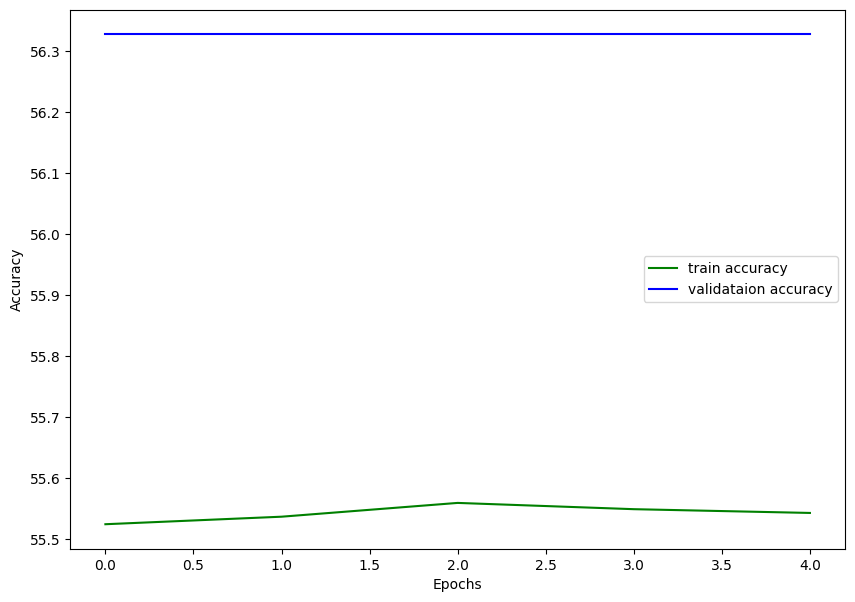

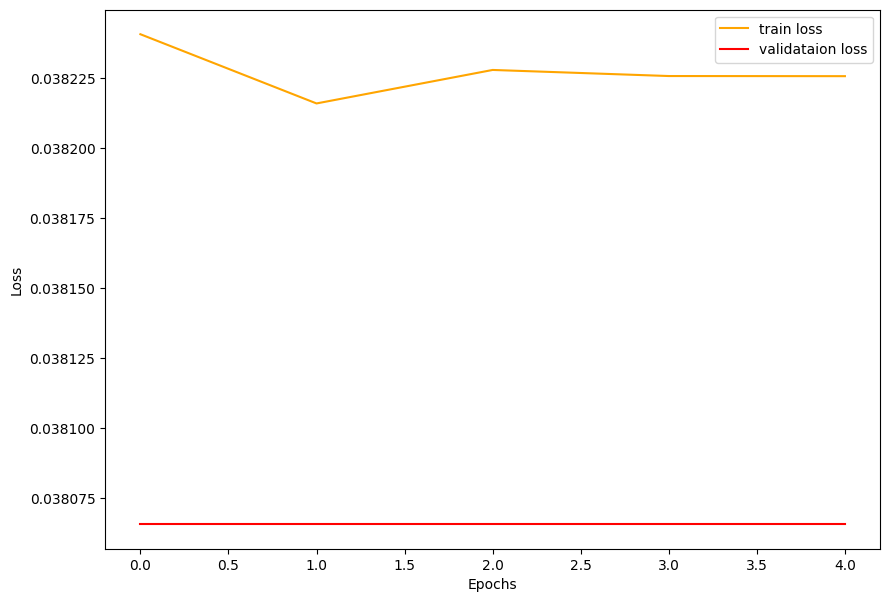

In [122]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(DIR_DATASET_MSASL + '/' + 'accuracy.png')
plt.show()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(DIR_DATASET_MSASL + '/' + 'loss.png')
plt.show()